## TradeMarquis: DistilBERT Model Fine Tuning

## Imports

In [1]:
import random
import json
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import DistilBertTokenizer, DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

## Data Manipulation

In [2]:
data = pd.read_csv("data\data.tsv", sep='\t', header=None)
data.head()

,0,1,2,3
0,0,28,a,"Meat, fish, poultry and game; Meat extracts; P..."
1,1,34,a,Business management and organization consultan...
2,2,29,a,"Vinegar; Salts, seasonings, flavourings and co..."
3,3,41,a,Conducting technical project studies; Scientif...
4,4,35,a,Brokerage; Brokerage house services; Agencies ...


In [3]:
# drop columns that don't contain useful data, such as index column
data=data.drop(data.columns[[0, 2]], axis=1)
# rename the columns
data.columns=["label", "text"]
# change the ordering of columns
data=data[["text", "label"]]
data.to_csv("data\data_proc.csv")
data.head()

,text,label
0,"Meat, fish, poultry and game; Meat extracts; P...",28
1,Business management and organization consultan...,34
2,"Vinegar; Salts, seasonings, flavourings and co...",29
3,Conducting technical project studies; Scientif...,41
4,Brokerage; Brokerage house services; Agencies ...,35


In [4]:
# max length of text entries
print(data.text.map(lambda x: len(x)).max())


200282


<AxesSubplot:>

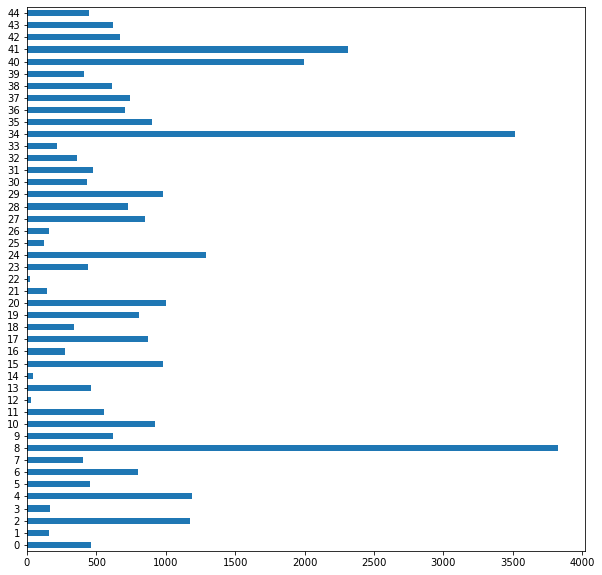

In [5]:
data['label'].value_counts().sort_index().plot(figsize=(10,10),kind='barh')

#### Label categories are statistically imbalanced, will need to stratify  later on

In [6]:
# creating a label dictionary 
labels = data.label.unique()
labels.sort()
label_dict = {}
for index, label in enumerate(labels):
    label_dict[f'NICE_{label}'] = index
len(label_dict)

# Serialize data into file:
json.dump( label_dict, open( "data\label_dict.json", 'w' ) )

## Data Preprocessing

#### Train, validation split
#### Due to label imbalance, split dataset in stratified fashion

In [7]:
X_train, X_val, y_train, y_val = train_test_split(data.index.values, 
                                                  data.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=data.label.values)
data['data_type'] = ['not_set']*data.shape[0]
data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'
grouped = data.groupby(['label', 'data_type']).count()
grouped

text
label data_type      
0     train       393
      val          69
1     train       135
      val          24
2     train       995
...               ...
42    val         101
43    train       526
      val          93
44    train       378
      val          67

[90 rows x 1 columns]

In [8]:
data

,text,label,data_type
0,"Meat, fish, poultry and game; Meat extracts; P...",28,train
1,Business management and organization consultan...,34,train
2,"Vinegar; Salts, seasonings, flavourings and co...",29,train
3,Conducting technical project studies; Scientif...,41,train
4,Brokerage; Brokerage house services; Agencies ...,35,train
...,...,...,...
34676,Pharmaceutical preparations for use in dermato...,4,train
34677,"Outdoor power equipment, namely, chainsaws, wo...",6,train
34678,"Raw and unprocessed agricultural, aquacultural...",30,train
34679,"Cooked truffles; Truffles, preserved; Dried tr...",28,val


#### Need to tokenize data and get the encoded input_ids, attention masks and label in the form of tensors

In [11]:
tokenizer=DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

encoded_data_train = tokenizer.batch_encode_plus(
    data[data.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    truncation=True,
    max_length=512, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    data[data.data_type=='val'].text.values,  
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    truncation=True,
    max_length=512, 
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data[data.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type=='val'].label.values)



In [12]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
len(dataset_train), len(dataset_val)

(29478, 5203)

In [18]:
# save the tensor data sets 
torch.save(dataset_train,'data\dataset_train.pt')
torch.save(dataset_val,'data\dataset_val.pt')

## DataLoading, Training and Eval 

#### This part of the notebook can be run separtely (after imports are ran) if the tensor datasets are saved in \data

In [3]:
dataset_train = torch.load('data\dataset_train.pt')
dataset_val = torch.load('data\dataset_val.pt')
label_dict = json.load( open( "data\label_dict.json" ) )

In [4]:
# Metrics functions
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def acc_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')


In [8]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                      num_labels=45,
                                                      output_attentions=False,
                                                      output_hidden_states=False)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

In [9]:
batch_size = 16
epochs = 5

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [10]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


In [11]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [12]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [13]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [19]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'results/finetuned_distillBERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    val_acc = acc_score_func(predictions, true_vals)
    
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Val F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Val Accuracy: {val_acc}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1843 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0134850200215113
Validation loss: 0.20941091643109278
Val F1 Score (Weighted): 0.9567338094862048
Val Accuracy: 0.9579088987122814


Epoch 2:   0%|          | 0/1843 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.12960675587130754
Validation loss: 0.11818767933994874
Val F1 Score (Weighted): 0.9702194261357824
Val Accuracy: 0.9702094945223909


Epoch 3:   0%|          | 0/1843 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.055495648872831406
Validation loss: 0.1119314511579767
Val F1 Score (Weighted): 0.973191571858497
Val Accuracy: 0.9732846434749183


Epoch 4:   0%|          | 0/1843 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.028050162613809278
Validation loss: 0.11009979209604821
Val F1 Score (Weighted): 0.9754857222814547
Val Accuracy: 0.9755910051893139


Epoch 5:   0%|          | 0/1843 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.01517304060387231
Validation loss: 0.11818882354735676
Val F1 Score (Weighted): 0.9745702658934599
Val Accuracy: 0.9746300211416491


Epoch 6:   0%|          | 0/1843 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.008013615982854272
Validation loss: 0.12196745187265726
Val F1 Score (Weighted): 0.9749829293943924
Val Accuracy: 0.9750144147607149


Epoch 7:   0%|          | 0/1843 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.004675987782534763
Validation loss: 0.12684326634091145
Val F1 Score (Weighted): 0.9736224408992157
Val Accuracy: 0.9736690370939842


Epoch 8:   0%|          | 0/1843 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                      num_labels=45,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model.load_state_dict(torch.load('results/finetuned_distillBERT_epoch_4.model')) # got best results in epoch 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [15]:

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)


Class: NICE_0
Accuracy: 57/69

Class: NICE_1
Accuracy: 24/24

Class: NICE_2
Accuracy: 172/176

Class: NICE_3
Accuracy: 23/25

Class: NICE_4
Accuracy: 174/179

Class: NICE_5
Accuracy: 66/68

Class: NICE_6
Accuracy: 114/120

Class: NICE_7
Accuracy: 60/61

Class: NICE_8
Accuracy: 567/574

Class: NICE_9
Accuracy: 89/93

Class: NICE_10
Accuracy: 132/139

Class: NICE_11
Accuracy: 81/83

Class: NICE_12
Accuracy: 4/4

Class: NICE_13
Accuracy: 68/69

Class: NICE_14
Accuracy: 6/6

Class: NICE_15
Accuracy: 146/147

Class: NICE_16
Accuracy: 38/41

Class: NICE_17
Accuracy: 130/131

Class: NICE_18
Accuracy: 46/51

Class: NICE_19
Accuracy: 113/121

Class: NICE_20
Accuracy: 148/151

Class: NICE_21
Accuracy: 18/21

Class: NICE_22
Accuracy: 3/3

Class: NICE_23
Accuracy: 63/66

Class: NICE_24
Accuracy: 194/194

Class: NICE_25
Accuracy: 19/19

Class: NICE_26
Accuracy: 22/23

Class: NICE_27
Accuracy: 124/127

Class: NICE_28
Accuracy: 109/109

Class: NICE_29
Accuracy: 144/147

Class: NICE_30
Accuracy: 64/65

### Testing